In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

You can get this data from ECDC website (European centre for disease preventiona and control)

In [4]:
raw_data = pd.read_excel(r'D:\Misc\covid_data_02_04.xlsx')

In [5]:
raw_data.head(5)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,2020-04-01,1,4,2020,25,0,Afghanistan,AF,AFG,37172386.0
1,2020-03-31,31,3,2020,27,0,Afghanistan,AF,AFG,37172386.0
2,2020-03-30,30,3,2020,8,1,Afghanistan,AF,AFG,37172386.0
3,2020-03-29,29,3,2020,15,1,Afghanistan,AF,AFG,37172386.0
4,2020-03-28,28,3,2020,16,1,Afghanistan,AF,AFG,37172386.0


In [7]:
raw_data.columns

Index(['dateRep', 'day', 'month', 'year', 'cases', 'deaths',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2018'],
      dtype='object')

In [8]:
drop_indices = ['day', 'month', 'year', 'geoId', 'countryterritoryCode']
raw_data = raw_data.drop(drop_indices, axis = 1)

## Adding Cmulative summations for cases and deaths
In this step first we are fetching the data countrywise. Since we have only daily reported data avilable, we need to find its cumulative sum as well. Once thats done, we will stack up the dataframes using concatebnation.

In [9]:
country_names = np.unique(raw_data.countriesAndTerritories.values)

for n, country in enumerate(country_names):
    country_df = raw_data.query('countriesAndTerritories=="%s"' % country)
    country_df = country_df.sort_values(by='dateRep', ascending=True)
    cases = country_df.cases
    deaths = country_df.deaths
    cases = cases.cumsum()
    deaths = deaths.cumsum()
    country_df.cases = cases
    country_df.deaths = deaths
    if not n:
        df = country_df
        continue
    df = pd.concat([df, country_df], ignore_index =True)
df_final = df.reset_index()
df_final = df_final.drop(['index'], axis =1)


### Upsampling the data
What I have observed plotting only with daily data is that, the frame transtions are not smooth. So we need to upsample the data with some level of interpolation.
To make a smooth video, let's upsample the data with 8 hour interval. 

Also interpolate the values for total number of cases

In [10]:
df_final_upsam = df_final.copy()
df_final_upsam.index = pd.to_datetime(df_final_upsam['dateRep'])
df_final_upsam = df_final_upsam.groupby('countriesAndTerritories').resample('8H').mean()
df_final_upsam.cases = df_final_upsam.cases.interpolate()
df_final_upsam.deaths = df_final_upsam.deaths.interpolate()
# converting to int array
df_final_upsam.cases = df_final_upsam.cases.astype(int)
df_final_upsam.deaths = df_final_upsam.deaths.astype(int)
df_final_upsam.popData2018 = df_final_upsam.popData2018.fillna(method='ffill')
country_name = pd.array([val[0] for val in df_final_upsam.index])
date_time = pd.array([val[1] for val in df_final_upsam.index])
df_final_upsam['countriesAndTerritories'] = country_name
df_final_upsam['dateRep'] = date_time

To get an idea just what happened, lets query for countrywise data and visualize it. 

In [11]:
df_final_upsam[df_final_upsam.countriesAndTerritories == 'United_States_of_America'][-10:]

cases  deaths  popData2018  \
countriesAndTerritories  dateRep                                            
United_States_of_America 2020-03-29 00:00:00  124665    2191  327167434.0   
                         2020-03-29 08:00:00  130785    2297  327167434.0   
                         2020-03-29 16:00:00  136905    2403  327167434.0   
                         2020-03-30 00:00:00  143025    2509  327167434.0   
                         2020-03-30 08:00:00  150223    2729  327167434.0   
                         2020-03-30 16:00:00  157421    2949  327167434.0   
                         2020-03-31 00:00:00  164620    3170  327167434.0   
                         2020-03-31 08:00:00  172952    3473  327167434.0   
                         2020-03-31 16:00:00  181285    3776  327167434.0   
                         2020-04-01 00:00:00  189618    4079  327167434.0   

                                               countriesAndTerritories  \
countriesAndTerritories  dateRep                                         
United_States_of_America 2020-03-29 00:00:00  United_States_of_America   
                         2020-03-29 08:00:00  United_States_of_America   
                         2020-03-29 16:00:00  United_States_of_America   
                         2020-03-30 00:00:00  United_States_of_America   
                         2020-03-30 08:00:00  United_States_of_America   
                         2020-03-30 16:00:00  United_States_of_America   
                         2020-03-31 00:00:00  United_States_of_America   
                         2020-03-31 08:00:00  United_States_of_America   
                         2020-03-31 16:00:00  United_States_of_America   
                         2020-04-01 00:00:00  United_States_of_America   

                                                         dateRep  
countriesAndTerritories  dateRep                                  
United_States_of_America 2020-03-29 00:00:00 2020-03-29 00:00:00  
                         2020-03-29 08:00:00 2020-03-29 08:00:00  
                         2020-03-29 16:00:00 2020-03-29 16:00:00  
                         2020-03-30 00:00:00 2020-03-30 00:00:00  
                         2020-03-30 08:00:00 2020-03-30 08:00:00  
                         2020-03-30 16:00:00 2020-03-30 16:00:00  
                         2020-03-31 00:00:00 2020-03-31 00:00:00  
                         2020-03-31 08:00:00 2020-03-31 08:00:00  
                         2020-03-31 16:00:00 2020-03-31 16:00:00  
                         2020-04-01 00:00:00 2020-04-01 00:00:00

Another interesting observation is that now the data frame has got a multi index. Also in the previous step, I have added another datetime based column taking from the index values(you can see that index values are tuples)

In [110]:
df_final = df_final_upsam

## Plotting a simple bar Chart
    
Lets start with a basic horizontal bar chart and plot for the day 01-04-2020

Here lets say we are interested to see top 5 values

Lets visualize top 10 values

<BarContainer object of 10 artists>

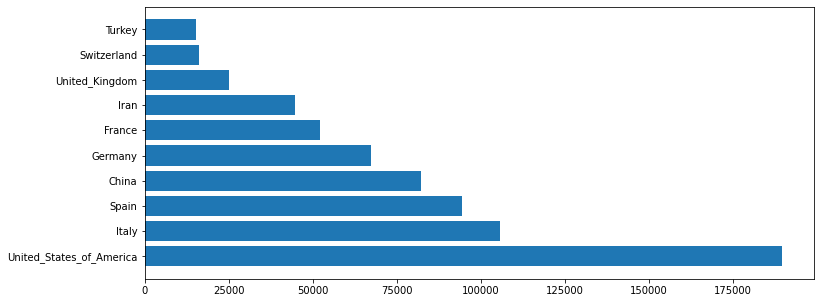

In [12]:
trial_day = pd.to_datetime('20200401', format='%Y%m%d', errors='ignore')
df_final = df_final.dropna()
df_trial = df_final[df_final['dateRep'] == trial_day]
df_trial = df_trial.sort_values(by='cases', ascending=False).head(10)

# plotting the chart

fig, ax = plt.subplots(figsize=(12, 5))
ax.barh(df_trial.countriesAndTerritories, df_trial.cases)

We can notice the highest bar is at the bottom, so we need to flip that

Also we need to set differen colors for different graphs.

Since we have a population column available, we can go for a population based color differentiation

In [13]:
pop_val = df_final.popData2018.values
color = np.full_like(pop_val, 0.0).astype(str)
color_list =  ['#adb0ff', '#ffb3ff', '#90d595', '#e48381', '#aafbff', '#eafb50', '#f7bb5f']

pop_list = [1e7, 2.5e7, 5e7, 7.5e7, 9e7, 4e8]
for i in range(len(pop_list) + 1):
    if not i:
        color[pop_val <= pop_list[i]] = color_list[i]
        continue
    if i == len(pop_list):
        color[pop_val > pop_list[-1]] = color_list[i]
        continue
    color[(pop_list[i - 1] <= pop_val) & (pop_val < pop_list[i])] = color_list[i]

In [113]:
df_trial

,,cases,deaths,popData2018,countriesAndTerritories,dateRep
countriesAndTerritories,dateRep,,,,,
United_States_of_America,2020-04-01,189618,4079,3.271674e+08,United_States_of_America,2020-04-01
Italy,2020-04-01,105792,12430,6.043128e+07,Italy,2020-04-01
Spain,2020-04-01,94417,8189,4.672375e+07,Spain,2020-04-01
China,2020-04-01,82295,3310,1.392730e+09,China,2020-04-01
Germany,2020-04-01,67366,732,8.292792e+07,Germany,2020-04-01
France,2020-04-01,52128,3523,6.698724e+07,France,2020-04-01
Iran,2020-04-01,44606,2898,8.180027e+07,Iran,2020-04-01
United_Kingdom,2020-04-01,25150,1789,6.648899e+07,United_Kingdom,2020-04-01
Switzerland,2020-04-01,16108,373,8.516543e+06,Switzerland,2020-04-01


Now we have different colors given to the countries, lets try plotting again

Text(1, 0.3, '2020-04-01')

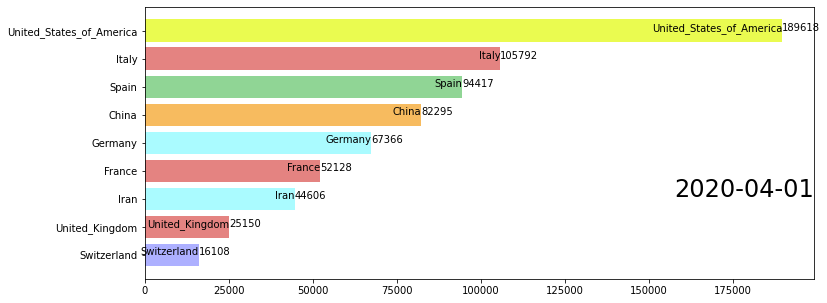

In [14]:
df_final['color'] = color
df_trial = df_final[df_final['dateRep'] == trial_day]
df_trial = df_trial.sort_values(by='cases', ascending=False).head(9)

df_trial = df_trial[::-1] # flip values from top to bottom
fig, ax = plt.subplots(figsize=(12, 5))
ax.barh(df_trial['countriesAndTerritories'], df_trial['cases'], color=df_trial.color.values)
# iterate over the values to plot labels and values
for i, (value, name) in enumerate(zip(df_trial['cases'], df_trial['countriesAndTerritories'])):
    ax.text(value, i,     name,            ha='right') 
    ax.text(value, i,     value,           ha='left') 
# Add year right middle portion of canvas
day = str(trial_day)
ax.text(1, 0.3, day.split()[0], transform=ax.transAxes, size=24, ha='right')


## Plotting Animation

The big step is to plot the animation. The method I have used here has got many line of code from a webpage, so thankfully mentioning those You guyys need to carefully go through these and understand.

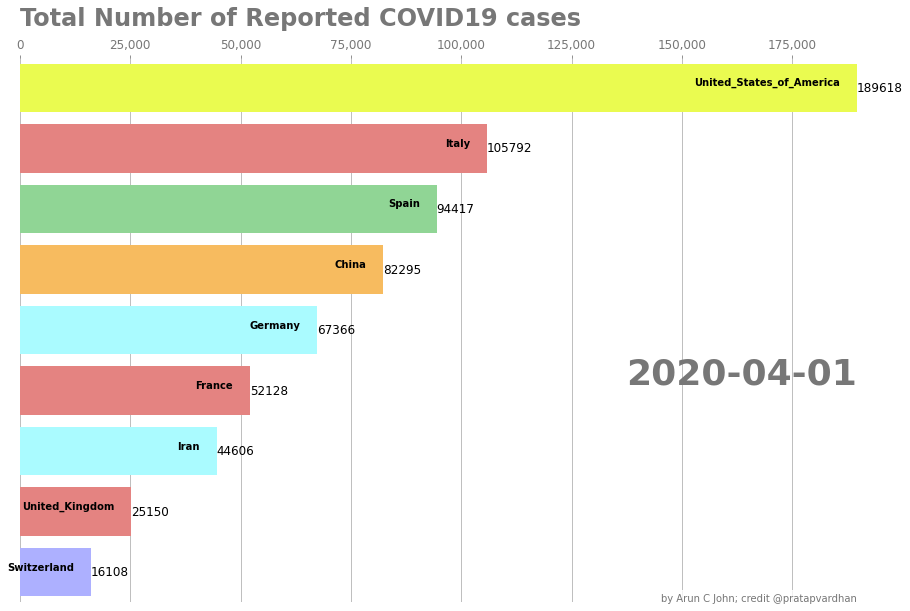

In [115]:
fig, ax = plt.subplots(figsize=(15, 10))
def draw_barchart(trial_day):
    df_final['color'] = color
    df_trial = df_final[df_final['dateRep'] == trial_day]
    df_trial = df_trial.sort_values(by='cases', ascending=False).head(9)
    df_trial = df_trial[::-1] # flip values from top to bottom
    ax.clear()
    ax.barh(df_trial['countriesAndTerritories'], df_trial['cases'], color=df_trial.color.values)
    dx = df_trial['cases'].max() / 50
    # iterate over the values to plot labels and values
    for i, (value, name) in enumerate(zip(df_trial['cases'], df_trial['countriesAndTerritories'])):
        ax.text(value- dx, i,     name,       size = 10, weight=800,     ha='right', va = 'bottom') 
        ax.text(value, i,     value,   size=12,        ha='left', va = 'center') 
    # Add year right middle portion of canvas
    day = str(trial_day)
    ax.text(1, 0.4, day.split()[0], transform=ax.transAxes, color='#777777', size=36, ha='right', weight=800)
    ax.text(0, 1.06, 'Total Number of Reported COVID19 cases', transform=ax.transAxes, size=24, color='#777777', weight=600)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(1, 0, 'by Arun C John; credit @pratapvardhan', transform=ax.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)

draw_barchart(trial_day)

## Animate Race
To animate the race, we will use FuncAnimation from matplotlib.animation. FuncAnimation creates an animation by repeatedly calling a function (that draws on canvas). In our case, that function will be draw_barchart. We also use frames, this argument accepts on what values you want to run draw_barchart. Here I have used custom range of dates, of course you should be able to play with those!.

<IPython.core.display.HTML object>

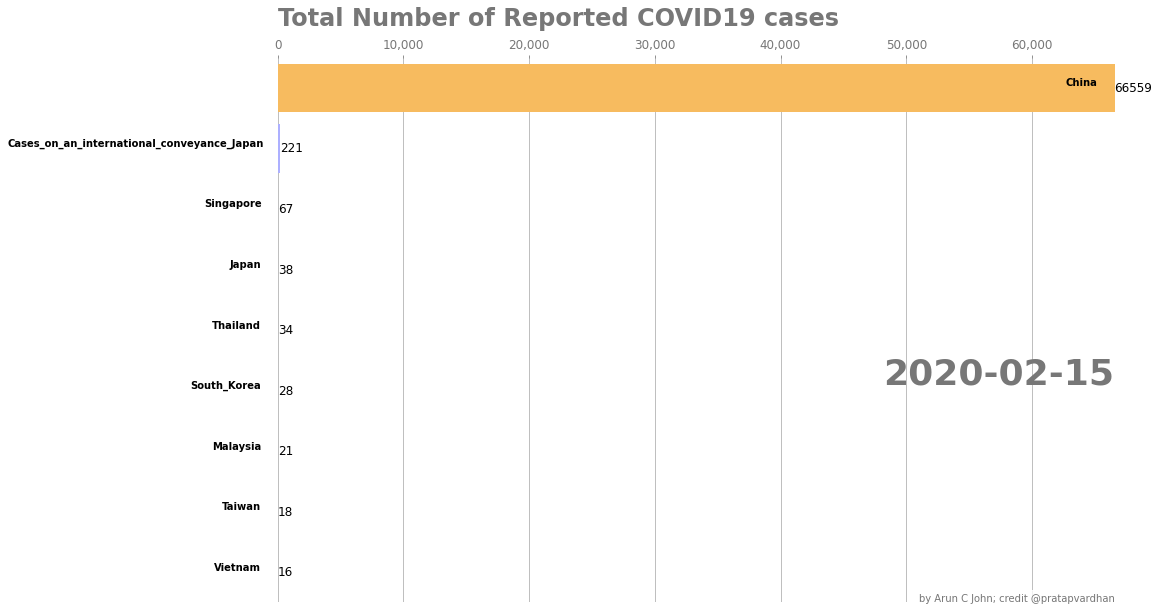

In [116]:
import matplotlib.animation as animation
from IPython.display import HTML
start_day = pd.to_datetime('20200215', format='%Y%m%d', errors='ignore')
fig, ax = plt.subplots(figsize=(15, 10))
animator = animation.FuncAnimation(fig, draw_barchart, frames=pd.date_range(start_day, df_final.dateRep.max(), freq='8H'))
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
HTML(animator.save('D:\Misc\movie.mp4'))